# Import Libraries and Load the Dataset

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [15]:
# Load the dataset
file_path = "travel booking analysis.csv"  # Update with actual file path
data = pd.read_csv(file_path)

# Display basic information
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279149 entries, 0 to 279148
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   profile_id                      279149 non-null  int64  
 1   primary_sales_product_type      279149 non-null  object 
 2   first_booking_time              279149 non-null  int64  
 3   first_issued_time               206554 non-null  float64
 4   last_booking_time               279149 non-null  int64  
 5   last_issued_time                206554 non-null  float64
 6   avg_booking_invoice_amount_idr  279149 non-null  float64
 7   avg_issued_invoice_amount_idr   206554 non-null  float64
 8   count_booking                   279149 non-null  int64  
 9   count_issued                    279149 non-null  int64  
 10  random_number                   279149 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 23.4+ MB
None
   profile_id p

# Preprocess Data

In [16]:
# Convert Unix timestamps to datetime
timestamp_columns = [
    'first_booking_time', 'first_issued_time',
    'last_booking_time', 'last_issued_time'
]

for col in timestamp_columns:
    data[col] = pd.to_datetime(data[col], unit='ms')

# Define churn
last_updated_date = pd.to_datetime("2019-02-01")  
one_year_ago = last_updated_date - timedelta(days=365)

# Add a churn column
data['is_churned'] = data['last_booking_time'] < one_year_ago

# Display churn summary
print(data['is_churned'].value_counts())

# Add a customer status column
data['status'] = data['is_churned'].apply(lambda x: 'Churned' if x else 'Active')

print(data[['profile_id', 'last_booking_time', 'status']].head())


is_churned
False    162277
True     116872
Name: count, dtype: int64
   profile_id       last_booking_time  status
0     3632279 2018-10-05 05:38:35.528  Active
1     3632279 2018-12-25 10:56:35.212  Active
2    17407638 2019-01-24 09:06:44.000  Active
3    17407638 2019-01-16 12:39:53.838  Active
4     4618047 2019-01-06 08:31:52.498  Active


# Aggregate Churned vs. Active Metrics

In [17]:
# Aggregate metrics for churned and active customers
aggregates = data.groupby('status').agg({
    'avg_booking_invoice_amount_idr': 'mean',
    'count_booking': 'sum',
    'count_issued': 'sum'
}).reset_index()

print(aggregates)


    status  avg_booking_invoice_amount_idr  count_booking  count_issued
0   Active                    1.226553e+06        2430086       1193528
1  Churned                    1.241231e+06         594361        248345


# Product-Wise Churn Analysis

In [18]:
# Product-wise churn analysis
product_churn = data.groupby(['primary_sales_product_type', 'is_churned']).size().unstack()
product_churn_percentage = product_churn.div(product_churn.sum(axis=1), axis=0) * 100

print(product_churn_percentage)


is_churned                      False      True 
primary_sales_product_type                      
FLIGHT                      52.795604  47.204396
HOTEL                       59.092268  40.907732
TRAIN                       71.370231  28.629769
TRIP                        70.316446  29.683554


# Visualization

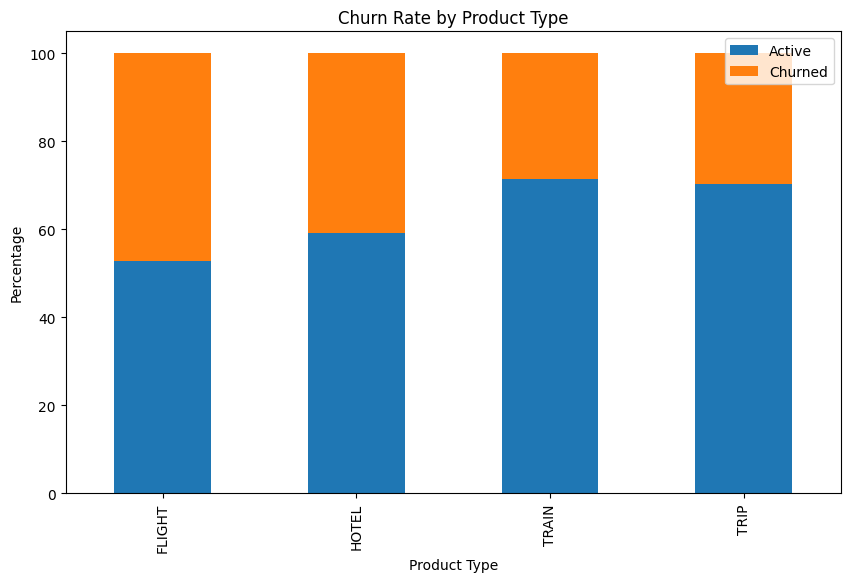

C:\Users\Electrobot\AppData\Local\Temp\ipykernel_6768\3441643053.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




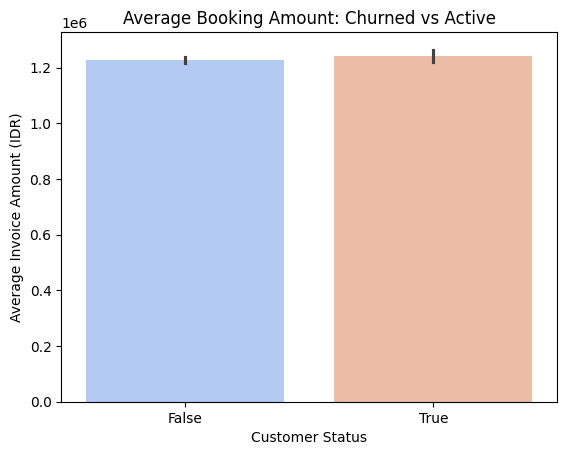

In [19]:
# Churn rate by product type
product_churn_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Churn Rate by Product Type")
plt.xlabel("Product Type")
plt.ylabel("Percentage")
plt.legend(['Active', 'Churned'])
plt.show()

# Average booking amount for churned vs active customers
sns.barplot(
    data=data, 
    x='is_churned', 
    y='avg_booking_invoice_amount_idr',
    palette='coolwarm'
)
plt.title("Average Booking Amount: Churned vs Active")
plt.xlabel("Customer Status")
plt.ylabel("Average Invoice Amount (IDR)")
plt.show()


# Build an Interactive Dashboard (Plotly)

We'll use Plotly for an interactive dashboard displaying:

1. Churn rates by product type.
2. Average booking amounts.
3. Total bookings by status.

In [20]:
import plotly.express as px
product_churn = data.groupby(['primary_sales_product_type', 'status']).size().unstack(fill_value=0)
product_churn_percentage = product_churn.div(product_churn.sum(axis=1), axis=0) * 100
product_churn_percentage = product_churn_percentage.reset_index()

# Churn rate visualization
fig1 = px.bar(
    product_churn_percentage.reset_index(),
    x='primary_sales_product_type',
    y=['Active', 'Churned'],
    title='Churn Rate by Product Type',
    labels={'value': 'Percentage', 'Primary_sales_product_type': 'Product Type'},
    barmode='stack'
)
fig1.show()

# Ensure numeric columns are selected for mean calculation
avg_booking_amount = (
    data.groupby('status')[['avg_booking_invoice_amount_idr']]
    .mean()
    .reset_index()
)

# Create the bar plot
fig2 = px.bar(
    avg_booking_amount,
    x='status',
    y='avg_booking_invoice_amount_idr',
    title='Average Booking Amount by Customer Status',
    labels={
        'avg_booking_invoice_amount_idr': 'Average Invoice Amount (IDR)',
        'status': 'Customer Status',
    }
)
fig2.show()


# Group data by product type and status, counting occurrences
total_bookings = (
    data.groupby(['primary_sales_product_type', 'status'])
    .size()
    .reset_index(name='Count')
)

# Create the bar plot
fig3 = px.bar(
    total_bookings,
    x='primary_sales_product_type',
    y='Count',
    color='status',
    title='Total Bookings by Product and Status',
    barmode='group',
    labels={
        'Count': 'Total Count',
        'Primary_sales_product_type': 'Product Type',
    }
)
fig3.show()



# Actionable Recommendations
1. Target Incentives for High-Churn Products: Focus on flight and hotel products, where churn rates are highest.
2. Increase Engagement: Personalized offers for at-risk customers based on historical preferences.
3. Build Loyalty Programs: Incentivize frequent bookers with point-based rewards.
4. Timely Campaigns: Send reminders or offers to inactive customers as they near the churn threshold.

# Next Steps
- Automate Reporting: Build pipelines to generate weekly churn reports.
- Predictive Modeling: Implement machine learning to forecast churn early.

# Predictive Modeling for Churn Prediction
Predicting churn involves using historical customer data to identify patterns that correlate with churned customers. Below is a step-by-step guide to implementing a churn prediction model using machine learning:

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset
data = pd.read_csv('travel booking analysis.csv')

# Define churned customers based on last booking
last_updated_date = pd.Timestamp('2019-02-01')  # Example last updated date
data['last_booking_time'] = pd.to_datetime(data['last_booking_time'], unit='ms')
data['churn'] = np.where(data['last_booking_time'] < (last_updated_date - pd.Timedelta(days=365)), 1, 0)

# Feature engineering
data['customer_tenure'] = (data['last_booking_time'] - pd.to_datetime(data['first_booking_time'], unit='ms')).dt.days
data['recency'] = (last_updated_date - data['last_booking_time']).dt.days

# Encode categorical variables
encoder = LabelEncoder()
data['primary_sales_product_type'] = encoder.fit_transform(data['primary_sales_product_type'])

# Drop unnecessary columns
features = data.drop(columns=['profile_id', 'first_booking_time', 'last_booking_time', 'churn'])
target = data['churn']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     48786
           1       1.00      1.00      1.00     34959

    accuracy                           1.00     83745
   macro avg       1.00      1.00      1.00     83745
weighted avg       1.00      1.00      1.00     83745



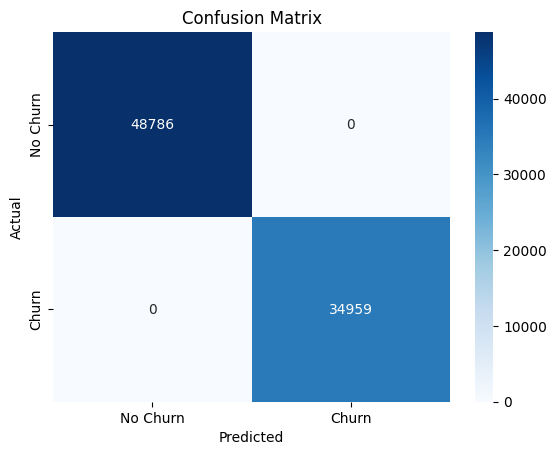

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


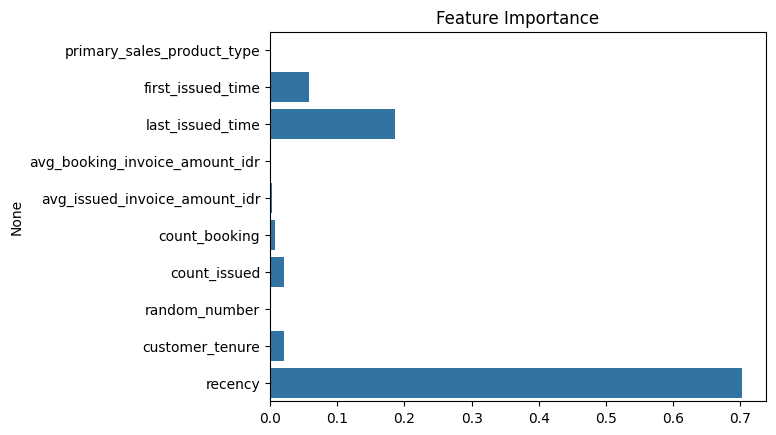

In [25]:
importances = model.feature_importances_
feature_names = features.columns

# Plot feature importances
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()
